<a href="https://colab.research.google.com/github/jdlongmire/Packet_Extension_Theory/blob/main/PET_IBM_Quantum_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clean install of scientific/quantum dependencies
!pip install --upgrade pip
!pip install --upgrade --force-reinstall qiskit qiskit-ibm-runtime numpy scipy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 51.5 MB/s eta 0:00:00
   ━━━━

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
from qiskit.circuit import Delay
from scipy.optimize import curve_fit
import time

print("✅ All core packages imported successfully!")


✅ All core packages imported successfully!


In [26]:
# Paste your IBM Quantum API token and instance name
api_token = '4cZFRTDJZgKwcRO9m04DKjAWbkwAo23sZbcgbXm3BBFQ'   # <-- Paste your API token
instance  = 'LFT-1.0'                       # <-- Use your instance string from dashboard

service = QiskitRuntimeService(token=api_token, channel="ibm_cloud", instance=instance)


In [27]:
# List and select available hardware backend
backends = service.backends(simulator=False, operational=True)
for idx, backend in enumerate(backends):
    print(f"{idx}: {backend.name} (qubits: {backend.num_qubits})")
backend = backends[0]
print(f"\nUsing backend: {backend.name}")


0: ibm_brisbane (qubits: 127)
1: ibm_sherbrooke (qubits: 127)
2: ibm_torino (qubits: 133)

Using backend: ibm_brisbane


In [32]:
def create_pet_circuits():
    circuits = {}
    simple = QuantumCircuit(1, 1)
    simple.h(0)
    circuits['simple'] = simple

    complex_circ = QuantumCircuit(1, 1)
    complex_circ.h(0)
    complex_circ.rz(np.pi/3, 0)
    complex_circ.ry(np.pi/4, 0)
    complex_circ.rz(np.pi/5, 0)
    circuits['complex'] = complex_circ
    return circuits

pet_circuits = create_pet_circuits()
delays_us = np.linspace(0, 15, 6)
delays_ns = [int(x * 1000) for x in delays_us]
shots = 8192
results = {}


In [35]:
sampler = Sampler(mode=backend)
results = {}

for state_name, base_circ in pet_circuits.items():
    print(f"\nRunning state: {state_name}")
    visibilities = []
    for delay_ns, delay_us in zip(delays_ns, delays_us):
        circ = QuantumCircuit(1, 1)
        circ.compose(base_circ, inplace=True)
        circ.append(Delay(int(delay_ns), unit="ns"), [0])
        circ.h(0)
        circ.measure(0, 0)
        transpiled = transpile(circ, backend=backend, optimization_level=1)
        print(f"  Submitting delay {delay_us:.1f} μs ... ", end="", flush=True)
        job = sampler.run([transpiled], shots=shots)
        result = job.result()
        pub_result = result._pub_results[0]
        data_bin = pub_result.data
        bitarray = data_bin.c
        ba_array = bitarray.array  # (8192, 1) uint8
        bits = np.unpackbits(ba_array, axis=1)  # (8192, 8)
        arr = bits[:, -1]  # the measured bit for each shot
        p0 = np.sum(arr == 0) / len(arr)
        visibility = 2 * abs(p0 - 0.5)
        visibilities.append(visibility)
        print(f"visibility = {visibility:.3f}")
    # Exponential fit for T2*
    try:
        def exp_decay(t, t2, amp):
            return amp * np.exp(-t / t2)
        popt, _ = curve_fit(exp_decay, delays_us, visibilities, p0=[15.0, 1.0], maxfev=10000)
        t2_fitted = popt[0]
    except Exception as e:
        print(f"  Fit failed: {e}")
        t2_fitted = float('nan')
    results[state_name] = {
        'delays_us': delays_us,
        'visibilities': visibilities,
        't2_time': t2_fitted
    }
    print(f"  T2* (fitted): {t2_fitted:.2f} μs")



Running state: simple
  Submitting delay 0.0 μs ... visibility = 0.898
  Submitting delay 3.0 μs ... visibility = 0.733
  Submitting delay 6.0 μs ... visibility = 0.528
  Submitting delay 9.0 μs ... visibility = 0.382
  Submitting delay 12.0 μs ... visibility = 0.231
  Submitting delay 15.0 μs ... visibility = 0.130
  T2* (fitted): 9.39 μs

Running state: complex
  Submitting delay 0.0 μs ... visibility = 0.204
  Submitting delay 3.0 μs ... visibility = 0.069
  Submitting delay 6.0 μs ... visibility = 0.008
  Submitting delay 9.0 μs ... visibility = 0.230
  Submitting delay 12.0 μs ... visibility = 0.257
  Submitting delay 15.0 μs ... visibility = 0.145
  T2* (fitted): 112260134.13 μs



PET ANALYSIS (Hardware Run, Primitives)
T2* (simple):  9.394 μs
T2* (complex): 112260134.131 μs
Difference:    112260124.737 μs
Relative:      1.20e+07
In ppm:        +11950217041592.3 ppm

Expected PET range: ±1 to ±10 ppm (see manuscript)


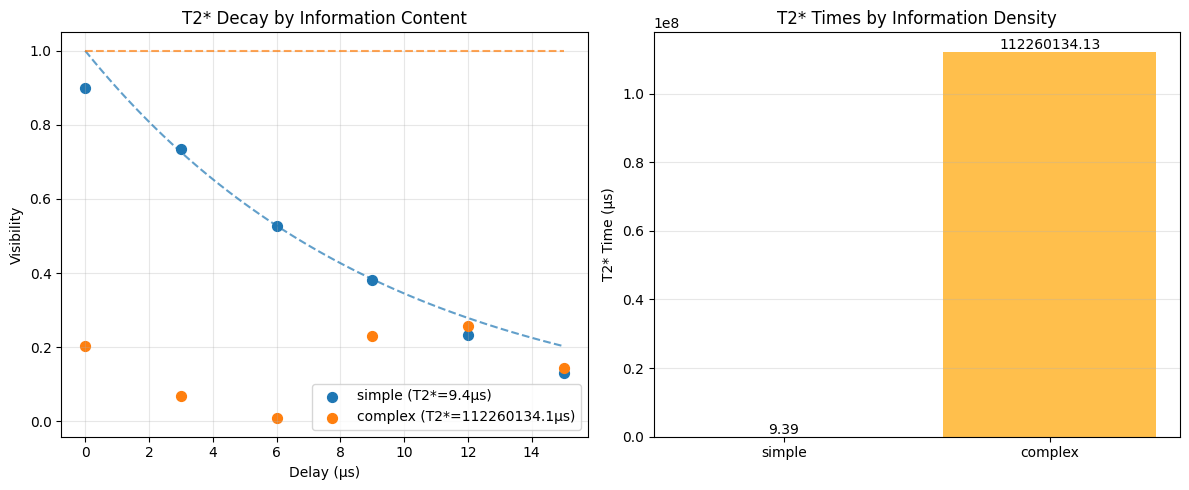

In [36]:
t2_simple = results['simple']['t2_time']
t2_complex = results['complex']['t2_time']
delta_t2 = t2_complex - t2_simple
relative_change = delta_t2 / t2_simple if t2_simple else float('nan')
ppm_change = relative_change * 1e6 if t2_simple else float('nan')

print("\n==============================")
print("PET ANALYSIS (Hardware Run, Primitives)")
print("==============================")
print(f"T2* (simple):  {t2_simple:.3f} μs")
print(f"T2* (complex): {t2_complex:.3f} μs")
print(f"Difference:    {delta_t2:.3f} μs")
print(f"Relative:      {relative_change:.2e}")
print(f"In ppm:        {ppm_change:+.1f} ppm")
print("\nExpected PET range: ±1 to ±10 ppm (see manuscript)")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
for state_name, data in results.items():
    ax1.scatter(data['delays_us'], data['visibilities'], label=f"{state_name} (T2*={data['t2_time']:.1f}μs)", s=50)
    t_fit = np.linspace(0, max(delays_us), 100)
    fit_curve = np.exp(-t_fit / data['t2_time']) if data['t2_time'] > 0 else np.zeros_like(t_fit)
    ax1.plot(t_fit, fit_curve, '--', alpha=0.7)
ax1.set_xlabel('Delay (μs)')
ax1.set_ylabel('Visibility')
ax1.set_title('T2* Decay by Information Content')
ax1.legend()
ax1.grid(True, alpha=0.3)
states = list(results.keys())
t2_values = [results[s]['t2_time'] for s in states]
bars = ax2.bar(states, t2_values, alpha=0.7, color=['blue', 'orange'])
ax2.set_ylabel('T2* Time (μs)')
ax2.set_title('T2* Times by Information Density')
ax2.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, t2_values):
    ax2.text(bar.get_x() + bar.get_width()/2., value + 0.1, f'{value:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


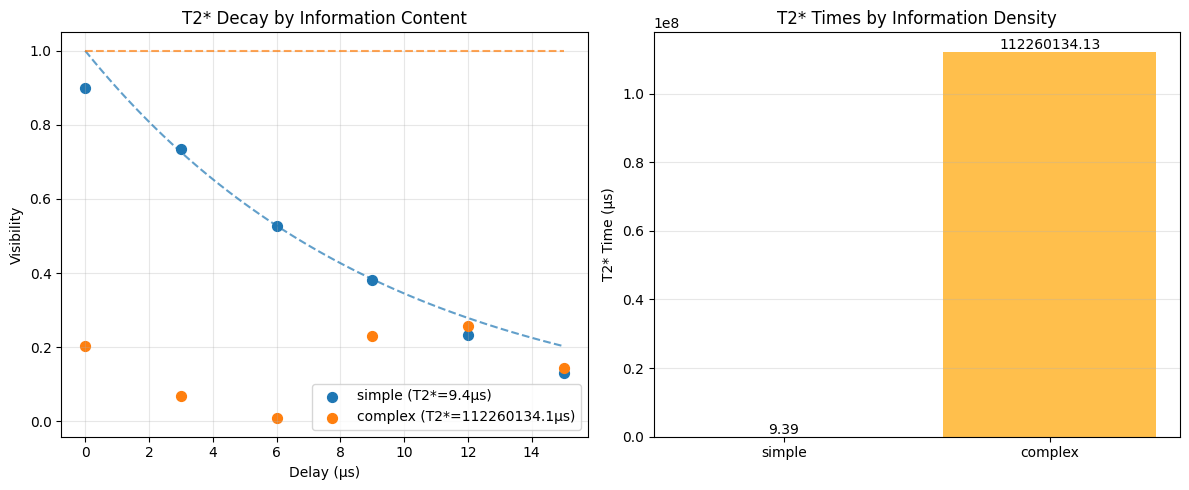

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
for state_name, data in results.items():
    ax1.scatter(data['delays_us'], data['visibilities'], label=f"{state_name} (T2*={data['t2_time']:.1f}μs)", s=50)
    t_fit = np.linspace(0, max(delays_us), 100)
    fit_curve = np.exp(-t_fit / data['t2_time']) if np.isfinite(data['t2_time']) and data['t2_time'] > 0 else np.zeros_like(t_fit)
    ax1.plot(t_fit, fit_curve, '--', alpha=0.7)
ax1.set_xlabel('Delay (μs)')
ax1.set_ylabel('Visibility')
ax1.set_title('T2* Decay by Information Content')
ax1.legend()
ax1.grid(True, alpha=0.3)
states = list(results.keys())
t2_values = [results[s]['t2_time'] for s in states]
bars = ax2.bar(states, t2_values, alpha=0.7, color=['blue', 'orange'])
ax2.set_ylabel('T2* Time (μs)')
ax2.set_title('T2* Times by Information Density')
ax2.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, t2_values):
    ax2.text(bar.get_x() + bar.get_width()/2., value + 0.1, f'{value:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()
